# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
97919,69470135,Infrastructure Solutions Architect,"Infrastructure Architect required, taking resp...",Nottingham East Midlands,Nottingham,NaN,permanent,NaN,IT Jobs,48000,48000,technojobs.co.uk,10.778977
110572,69670902,Electrical Maintenance Engineer,Electrical Maintenance Engineer **** to **** B...,South Molton,South Molton,NaN,permanent,Future Engineering Recruitment Ltd,Engineering Jobs,"24k - 30k pa + Overtime, Pension, Progression",27000,jobsite.co.uk,10.203629
92621,69182104,Hotel Receptionist Falmouth **** Stunning H...,Hotel Receptionist Falmouth **** Stunning H...,"Falmouth, Cornwall, UK, Cornwall",Falmouth,NaN,NaN,Paramount Personnel,Hospitality & Catering Jobs,"Up to 14,000 per annum",14000,jobs.catererandhotelkeeper.com,9.546884


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for col in text_columns:
    for text in data[col]:
        tokens = tokenizer.tokenize(text)
        token_counts.update(tokens)

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

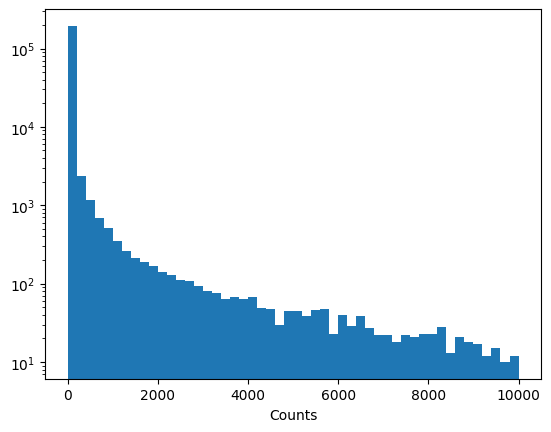

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [token for token, count in token_counts.items() if count >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[1988, 4200,    1,    1,    1,    1,    1],
        [ 141,  363,  581,   15,  221,    1,    1],
        [  58,   97,   11,  992,   27,   61, 2329]]),
 'FullDescription': array([[ 3199,  2241,  2497,  1617,    73,   561,  1988,  4200,    86,
          2692],
        [  369,    87,   363,    15,   581,    15,   221,    15,    74,
            74],
        [   58,    97,    11, 12427,   992,    27,    61,    92,    86,
            74]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([10.01122 , 10.178312, 10.819798], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [20]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.pool1(F.relu(self.conv1(h)))
        h = self.dense(h)
        
        return h

In [21]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [22]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)  # [batch_size, max_len, emb_size]
        h = torch.transpose(h, 1, 2)  # [batch_size, emb_size, max_len]
        h = self.pool1(F.relu(self.conv1(h)))  # Apply conv -> relu -> max pool
        h = self.dense(h)  # Final dense layer
        return h

In [23]:
desc_encoder = DescriptionEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [24]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(n_tokens=n_tokens, out_size=64)
        
        # define layers for categorical features. A few dense layers would do.
        self.cat_layer1 = nn.Linear(n_cat_features, 32)
        self.cat_layer2 = nn.Linear(32, 16)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.final_layer1 = nn.Linear(64 + 64 + 16, 64)  # title + desc + cat
        self.final_layer2 = nn.Linear(64, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = F.relu(self.cat_layer1(cat_features))
        cat_h = self.cat_layer2(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        joint_h = F.relu(self.final_layer1(joint_h))
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        output = self.final_layer2(joint_h)

        return output[:, 0]

In [25]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [26]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [27]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [28]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [29]:
from tqdm.notebook import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [30]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [31]:
for epoch_i in range(num_epochs):
    print(f'Epoch: {epoch_i}')
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Epoch: 0
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	10.97050
	MAE:	27683.80010



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.66934
	MAE:	8347.80346



Epoch: 1
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.57751
	MAE:	7007.57811



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.46843
	MAE:	6091.28215



Epoch: 2
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.41779
	MAE:	5884.86053



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.35152
	MAE:	5476.15607



Epoch: 3
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.31629
	MAE:	5114.45787



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.29791
	MAE:	5233.11105



Epoch: 4
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.28470
	MAE:	4935.42594



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.25845
	MAE:	4672.11907



Epoch: 5
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.24634
	MAE:	4523.13265



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.23921
	MAE:	4723.83229



Epoch: 6
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.22904
	MAE:	4360.93311



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.21507
	MAE:	4199.17723



Epoch: 7
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.20681
	MAE:	4307.03402



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.22087
	MAE:	4794.30851



Epoch: 8
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.19505
	MAE:	4111.31231



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18511
	MAE:	4019.12431



Epoch: 9
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18469
	MAE:	3940.87790



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.19970
	MAE:	3896.20105



Epoch: 10
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.18831
	MAE:	3978.45560



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16351
	MAE:	3741.97763



Epoch: 11
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16380
	MAE:	3797.54936



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16175
	MAE:	3895.72557



Epoch: 12
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16803
	MAE:	3817.20449



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14969
	MAE:	3609.96140



Epoch: 13
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.15490
	MAE:	3701.89785



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15003
	MAE:	3777.62967



Epoch: 14
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14734
	MAE:	3680.01216



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.15579
	MAE:	3580.31371



Epoch: 15
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14338
	MAE:	3606.40728



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16332
	MAE:	4177.59075



Epoch: 16
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.16174
	MAE:	3776.28409



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13526
	MAE:	3430.09416



Epoch: 17
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.14410
	MAE:	3610.99812



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13812
	MAE:	3409.35775



Epoch: 18
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13428
	MAE:	3479.46518



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.16159
	MAE:	4182.42279



Epoch: 19
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13430
	MAE:	3415.88492



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13932
	MAE:	3408.36373



Epoch: 20
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13650
	MAE:	3566.17143



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18754
	MAE:	4796.90829



Epoch: 21
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.13171
	MAE:	3484.92010



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12558
	MAE:	3498.19710



Epoch: 22
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12225
	MAE:	3326.17902



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11809
	MAE:	3187.40835



Epoch: 23
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12442
	MAE:	3312.38836



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11311
	MAE:	3185.52266



Epoch: 24
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11488
	MAE:	3250.18892



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.18538
	MAE:	4775.15722



Epoch: 25
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12942
	MAE:	3501.51993



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11063
	MAE:	3121.22802



Epoch: 26
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11642
	MAE:	3251.57151



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10971
	MAE:	3154.78523



Epoch: 27
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11185
	MAE:	3259.49864



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11152
	MAE:	3108.92225



Epoch: 28
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10961
	MAE:	3236.09416



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10996
	MAE:	3107.03932



Epoch: 29
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11652
	MAE:	3268.25766



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11301
	MAE:	3128.07938



Epoch: 30
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.12109
	MAE:	3343.75212



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11285
	MAE:	3240.54907



Epoch: 31
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09649
	MAE:	2969.15260



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10419
	MAE:	3092.58597



Epoch: 32
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10995
	MAE:	3239.69242



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10743
	MAE:	3065.13749



Epoch: 33
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10946
	MAE:	3078.52169



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10588
	MAE:	3158.99438



Epoch: 34
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11090
	MAE:	3142.85677



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13932
	MAE:	3446.23074



Epoch: 35
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10263
	MAE:	3119.22387



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.14578
	MAE:	3535.00675



Epoch: 36
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11693
	MAE:	3254.91046



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09867
	MAE:	2965.39390



Epoch: 37
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10159
	MAE:	3048.99367



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09696
	MAE:	2965.55031



Epoch: 38
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10605
	MAE:	3189.01626



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10202
	MAE:	3108.18341



Epoch: 39
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09638
	MAE:	3014.39857



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09489
	MAE:	2915.48411



Epoch: 40
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09656
	MAE:	2944.14921



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10530
	MAE:	3184.65265



Epoch: 41
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.11033
	MAE:	3191.64717



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12291
	MAE:	3253.61408



Epoch: 42
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10558
	MAE:	3066.37854



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09436
	MAE:	2930.24042



Epoch: 43
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09824
	MAE:	3014.61986



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09465
	MAE:	2915.27506



Epoch: 44
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10561
	MAE:	3218.25140



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09577
	MAE:	2905.89520



Epoch: 45
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09148
	MAE:	2916.32159



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09373
	MAE:	2874.17924



Epoch: 46
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09404
	MAE:	2957.90200



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09131
	MAE:	2851.51517



Epoch: 47
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09432
	MAE:	2978.49623



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11722
	MAE:	3206.32703



Epoch: 48
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08966
	MAE:	2896.67344



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09430
	MAE:	2984.69995



Epoch: 49
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08668
	MAE:	2829.04615



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09588
	MAE:	2911.16820



Epoch: 50
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09069
	MAE:	2939.82736



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09254
	MAE:	2858.72144



Epoch: 51
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09593
	MAE:	2913.11383



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09142
	MAE:	2850.16662



Epoch: 52
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08971
	MAE:	2887.91980



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08771
	MAE:	2802.47346



Epoch: 53
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09886
	MAE:	2996.31482



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10051
	MAE:	3147.73692



Epoch: 54
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09456
	MAE:	3010.76125



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08848
	MAE:	2795.90181



Epoch: 55
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09630
	MAE:	3033.26751



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08809
	MAE:	2809.54531



Epoch: 56
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08532
	MAE:	2757.38438



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09261
	MAE:	2958.93828



Epoch: 57
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08773
	MAE:	2811.17782



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10125
	MAE:	3163.59679



Epoch: 58
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09223
	MAE:	2964.14514



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08557
	MAE:	2789.72960



Epoch: 59
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08122
	MAE:	2768.75323



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09369
	MAE:	2981.16807



Epoch: 60
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09323
	MAE:	2926.15317



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10355
	MAE:	3029.05130



Epoch: 61
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09001
	MAE:	2846.29777



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10764
	MAE:	3340.04066



Epoch: 62
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09518
	MAE:	3021.81078



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09788
	MAE:	2950.40920



Epoch: 63
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08085
	MAE:	2741.73372



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09351
	MAE:	3054.45688



Epoch: 64
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09362
	MAE:	2855.98101



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08473
	MAE:	2769.56014



Epoch: 65
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08404
	MAE:	2789.51036



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08554
	MAE:	2783.57805



Epoch: 66
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08653
	MAE:	2877.37760



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09129
	MAE:	2857.20157



Epoch: 67
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07966
	MAE:	2699.37458



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08998
	MAE:	2815.00496



Epoch: 68
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08369
	MAE:	2692.19099



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09425
	MAE:	3072.67072



Epoch: 69
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08346
	MAE:	2812.69966



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09155
	MAE:	2969.38502



Epoch: 70
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08083
	MAE:	2740.41827



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08267
	MAE:	2772.71711



Epoch: 71
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08942
	MAE:	2911.18065



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09414
	MAE:	2861.60465



Epoch: 72
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07950
	MAE:	2755.45678



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08458
	MAE:	2736.24981



Epoch: 73
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09840
	MAE:	3017.54451



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09261
	MAE:	2854.93779



Epoch: 74
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08334
	MAE:	2780.49482



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11915
	MAE:	3257.10886



Epoch: 75
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07845
	MAE:	2667.07029



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08067
	MAE:	2697.08122



Epoch: 76
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08314
	MAE:	2774.12632



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08359
	MAE:	2742.80864



Epoch: 77
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08768
	MAE:	2799.14600



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11032
	MAE:	3106.09542



Epoch: 78
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.09079
	MAE:	2841.38413



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08590
	MAE:	2759.04009



Epoch: 79
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08276
	MAE:	2741.43891



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08472
	MAE:	2749.40864



Epoch: 80
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.10109
	MAE:	3034.84765



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08663
	MAE:	2763.53284



Epoch: 81
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08451
	MAE:	2793.51182



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08051
	MAE:	2715.35597



Epoch: 82
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07746
	MAE:	2681.94783



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08047
	MAE:	2712.65392



Epoch: 83
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08251
	MAE:	2767.64565



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.11049
	MAE:	3171.53788



Epoch: 84
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07538
	MAE:	2623.42926



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07992
	MAE:	2698.71683



Epoch: 85
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08540
	MAE:	2748.19469



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09017
	MAE:	2828.70912



Epoch: 86
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07833
	MAE:	2710.12152



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07896
	MAE:	2679.22738



Epoch: 87
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08507
	MAE:	2714.23166



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08765
	MAE:	2904.80971



Epoch: 88
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07579
	MAE:	2614.82315



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07922
	MAE:	2693.65199



Epoch: 89
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07637
	MAE:	2710.12771



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08006
	MAE:	2674.82088



Epoch: 90
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08443
	MAE:	2744.14458



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07795
	MAE:	2641.91138



Epoch: 91
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08006
	MAE:	2852.32742



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07760
	MAE:	2645.44515



Epoch: 92
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08100
	MAE:	2610.79557



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08006
	MAE:	2674.21778



Epoch: 93
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08495
	MAE:	2732.37799



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07872
	MAE:	2649.24486



Epoch: 94
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07381
	MAE:	2589.27608



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07615
	MAE:	2620.08768



Epoch: 95
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07423
	MAE:	2656.11248



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08102
	MAE:	2761.49185



Epoch: 96
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07723
	MAE:	2652.81783



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07940
	MAE:	2648.99092



Epoch: 97
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07564
	MAE:	2567.26833



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10281
	MAE:	3297.29580



Epoch: 98
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07587
	MAE:	2642.79362



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07712
	MAE:	2641.91922



Epoch: 99
Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08119
	MAE:	2837.50684



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07606
	MAE:	2633.48200





In [32]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

loss_old = val_loss / val_batches
mae_old = val_mae / val_batches

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07606
	MAE:	2633.48200





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

In [33]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.pool1 = GlobalMaxPooling()        
        self.bn1 = nn.BatchNorm1d(2 * out_size)
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(2 * out_size, out_size)
        
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h1 = F.relu(self.conv1(h))
        h2 = F.relu(self.conv2(h))
        h = torch.cat([self.pool1(h1), self.pool1(h2)], dim=1)
        h = self.bn1(h)
        h = self.dropout(h)
        h = self.dense(h)
        return h

In [34]:
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=5, padding=2)
        self.pool1 = GlobalMaxPooling()        
        self.bn1 = nn.BatchNorm1d(2 * out_size)
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(2 * out_size, out_size)
        
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h1 = F.relu(self.conv1(h))
        h2 = F.relu(self.conv2(h))
        h = torch.cat([self.pool1(h1), self.pool1(h2)], dim=1)
        h = self.bn1(h)
        h = self.dropout(h)
        h = self.dense(h)
        return h

In [35]:
class FullNetwork(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoder(n_tokens=n_tokens, out_size=64)
        self.cat_layer1 = nn.Linear(n_cat_features, 32)
        self.cat_layer2 = nn.Linear(32, 16)
        self.final_layer1 = nn.Linear(64 + 64 + 16, 64)
        self.final_layer2 = nn.Linear(64, 1)
    def forward(self, title_ix, desc_ix, cat_features):
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        cat_h = F.relu(self.cat_layer1(cat_features))
        cat_h = self.cat_layer2(cat_h)
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        joint_h = F.relu(self.final_layer1(joint_h))
        output = self.final_layer2(joint_h)
        return output[:, 0]

In [36]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [37]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 2000
patience = 5
best_val_loss = float("inf")

In [38]:
for epoch_i in range(num_epochs):
    print(f'Epoch: {epoch_i}')
    print("Training:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1
    val_loss /= val_batches
    val_mae /= val_batches
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f'Epochs without improvements: {early_stopping_counter} out of {patience}')
        if early_stopping_counter >= patience:
            print(f"Early stopping on epoch {epoch_i}")
            model.load_state_dict(best_model)
            break

Epoch: 0
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	1.81785
	MAE:	906012.95982



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00017
	MAE:	4.53218



Epoch: 1
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.13525
	MAE:	3557.94944



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00019
	MAE:	4.60669



Epochs without improvements: 1 out of 5
Epoch: 2
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.11903
	MAE:	3349.63060



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00014
	MAE:	3.99299



Epoch: 3
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.10983
	MAE:	3211.39181



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00012
	MAE:	3.81282



Epoch: 4
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.10150
	MAE:	3090.57782



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00012
	MAE:	3.83306



Epoch: 5
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.09493
	MAE:	2988.71350



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00013
	MAE:	3.89652



Epochs without improvements: 1 out of 5
Epoch: 6
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.08858
	MAE:	2886.85569



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00010
	MAE:	3.38779



Epoch: 7
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.08582
	MAE:	2841.90075



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00012
	MAE:	3.72218



Epochs without improvements: 1 out of 5
Epoch: 8
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.08286
	MAE:	2777.95344



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00011
	MAE:	3.56716



Epochs without improvements: 2 out of 5
Epoch: 9
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.07858
	MAE:	2723.93940



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00009
	MAE:	3.28122



Epoch: 10
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.07569
	MAE:	2659.10526



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00009
	MAE:	3.38952



Epochs without improvements: 1 out of 5
Epoch: 11
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.07306
	MAE:	2612.47333



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	3.14064



Epoch: 12
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.07130
	MAE:	2598.77748



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00009
	MAE:	3.17894



Epochs without improvements: 1 out of 5
Epoch: 13
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.06915
	MAE:	2548.57156



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	3.05217



Epoch: 14
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.06720
	MAE:	2493.04127



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00009
	MAE:	3.17231



Epochs without improvements: 1 out of 5
Epoch: 15
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.06625
	MAE:	2483.36021



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00010
	MAE:	3.48097



Epochs without improvements: 2 out of 5
Epoch: 16
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.06391
	MAE:	2444.50394



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	2.97529



Epoch: 17
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.06064
	MAE:	2392.69385



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	2.96474



Epoch: 18
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.05964
	MAE:	2376.14384



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	2.98641



Epochs without improvements: 1 out of 5
Epoch: 19
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.06018
	MAE:	2376.61807



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	3.08828



Epochs without improvements: 2 out of 5
Epoch: 20
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.05889
	MAE:	2346.42916



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00009
	MAE:	3.10283



Epochs without improvements: 3 out of 5
Epoch: 21
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.05685
	MAE:	2309.57254



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	3.04786



Epochs without improvements: 4 out of 5
Epoch: 22
Training:


  0%|          | 0/2000 [00:00<?, ?it/s]

	Loss:	0.05648
	MAE:	2295.70531



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.00008
	MAE:	2.96356



Epochs without improvements: 5 out of 5
Early stopping on epoch 22


In [39]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

loss_new = val_loss / val_batches
mae_new = val_mae / val_batches

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.05996
	MAE:	2267.11962





In [40]:
print(f"Old Model - Loss: {loss_old:.5f}, MAE: {mae_old:.2f}")
print(f"New Model - Loss: {loss_new:.5f}, MAE: {mae_new:.2f}")

improvement_loss = (loss_old - loss_new) / loss_old * 100
improvement_mae = (mae_old - mae_new) / mae_old * 100

print(f"\nImprovement in Loss: {improvement_loss:.2f}%")
print(f"Improvement in MAE: {improvement_mae:.2f}%")


Old Model - Loss: 0.07606, MAE: 2633.48
New Model - Loss: 0.05996, MAE: 2267.12

Improvement in Loss: 21.16%
Improvement in MAE: 13.91%


### A short report

Please tell us what you did and how did it work.

1) A second convolutional layer with a kernel size of 5 is added to each encoder (title and description), which helps extract more information from the sequences.
2) The outputs of both convolutional layers are concatenated using `torch.cat`, which creates 2x more features, which has a beneficial effect on extracting additional information.
3) BatchNorm and Dropout are used for normalization and regularization, respectively. This helps stabilize the training and reduce the risk of overfitting.
4) The dense layer is set to double the size to accommodate the increased number of features from the two convolutional layers.
5) Early stopping was used during training, which allowed us to preserve the best parameters without the risk of overfitting the model.
6) The number of simultaneously processed batches was also increased to 2000.